#The coding task

The coding task consists of two parts. First, you need to predict the target variable `is_positive` using your chosen method. Second, you need to perform inference on the same texts using the output of the BART model and compare the results of the two models. We provide predictions for this step in the smaller version of the dataset to assist you.

1. Load the dataset (small).

2. Perform preprocessing and cleaning steps of your choice.

3. Train a model (Choose a method/architecture you find suitable).

4. Validate the model's performance in terms of predictive accuracy and generalizability. You are free to choose relevant metrics for this task.

5. Make additional predictions using the BART model (or use the small dataset with the precomputed predictions) and validate the results. Compare these results to the ones obtained from the model trained in the previous step.

6. Present your code, descriptive analysis, and model performance.

In [2]:
# importing required libraries and modules

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import string
import re
import numpy as np
from collections import Counter
import logging
import time
import pickle
import itertools
import random
import datetime

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict

import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
#read the data

twitter_data = pd.read_csv("/content/twitter_dataset_small_w_bart_preds.csv")
twitter_data.head()

,is_positive,id,datetime,user,message,bart_is_positive
0,0,2200003313,Tue Jun 16 18:18:13 PDT 2009,DEWGetMeTho77,@Nkluvr4eva My poor little dumpling In Holmde...,0.005163
1,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,Young_J,I'm off too bed. I gotta wake up hella early t...,0.339430
2,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,dougnawoschik,I havent been able to listen to it yet My spe...,0.065703
3,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,thireven,now remembers why solving a relatively big equ...,0.004046
4,0,2256551006,Sat Jun 20 12:56:51 PDT 2009,taracollins086,"Ate too much, feel sick",0.000581


In [4]:
# dataframe to inspect the dimensions and obtain concise summary

twitter_data.shape
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   is_positive       20000 non-null  int64  
 1   id                20000 non-null  int64  
 2   datetime          20000 non-null  object 
 3   user              20000 non-null  object 
 4   message           20000 non-null  object 
 5   bart_is_positive  20000 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 937.6+ KB


In [5]:
# Deeper dive to obtain the attributes of is_positive column

twitter_data['is_positive'].value_counts()

1    10058
0     9942
Name: is_positive, dtype: int64

In [6]:
# removing the columns that are not necessary for training/testing

data = twitter_data.drop(['id', 'datetime', 'user', 'bart_is_positive'], axis=1)
data

,is_positive,message
0,0,@Nkluvr4eva My poor little dumpling In Holmde...
1,0,I'm off too bed. I gotta wake up hella early t...
2,0,I havent been able to listen to it yet My spe...
3,0,now remembers why solving a relatively big equ...
4,0,"Ate too much, feel sick"
...,...,...
19995,1,@girlwonder24 Thanks.
19996,0,"trying to study for the biggest test, next wee..."
19997,1,Just finished watching Your Song Presents: Boy...
19998,1,@janfran813 awww i can't wait to get one


In [7]:
print(data['message'][0])
print(data['message'][1])

@Nkluvr4eva My poor little dumpling  In Holmdel vids he was really trying...Hope he dont try to hard tonight xx
I'm off too bed. I gotta wake up hella early tomorrow morning. 


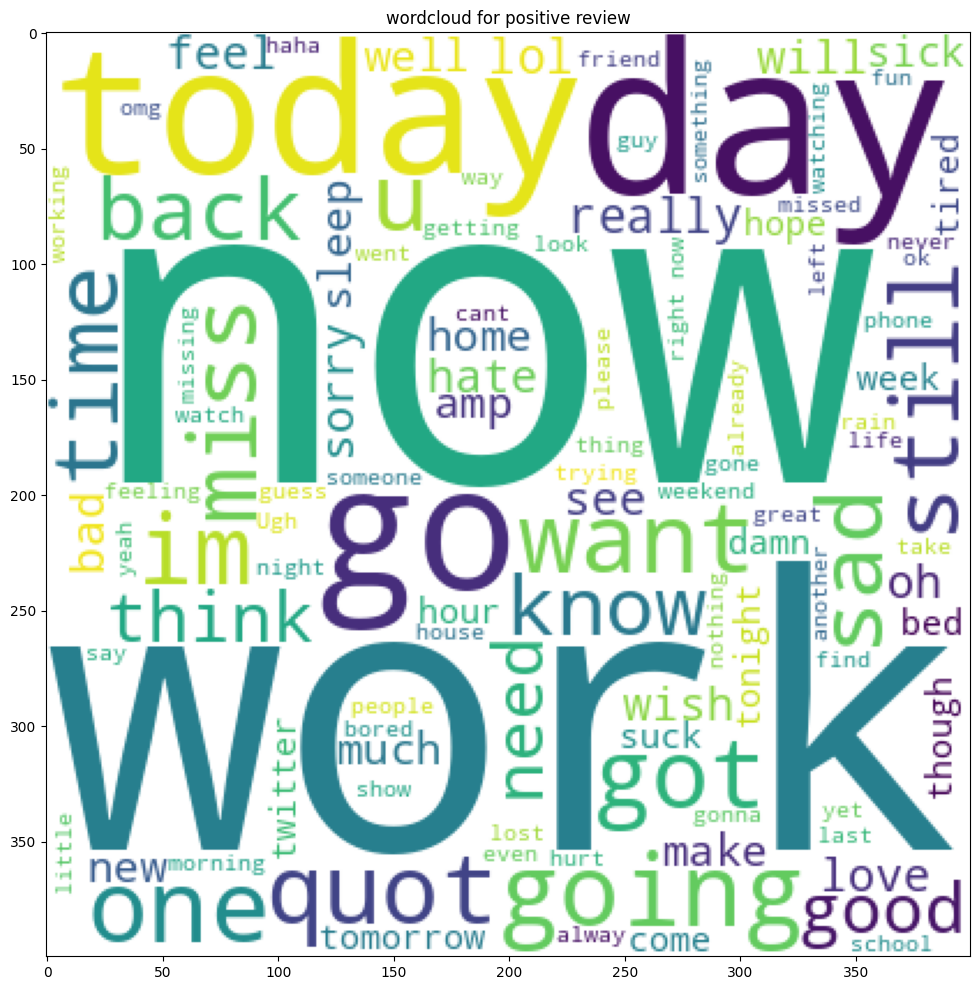

In [8]:
# visualizing the data with wordcloud

from wordcloud import WordCloud
wc = WordCloud(width = 400, height = 400, min_font_size = 10, background_color = 'white')
positive_tweets = wc.generate(twitter_data[twitter_data['is_positive'] == 1.0]['message'].str.cat(sep = " "))
negative_tweets = wc.generate(twitter_data[twitter_data['is_positive'] == 0.0]['message'].str.cat(sep = " "))
plt.figure(figsize = (12, 12))
plt.title('wordcloud for positive review')
plt.imshow(positive_tweets)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   is_positive  20000 non-null  int64 
 1   message      20000 non-null  object
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [10]:
# setting up decoding map

decode_map = {0.0: "NEGATIVE", 1.0: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

data.is_positive = data.is_positive.apply(lambda x: decode_sentiment(x))

Text(0.5, 1.0, 'Dataset labels distribuition')

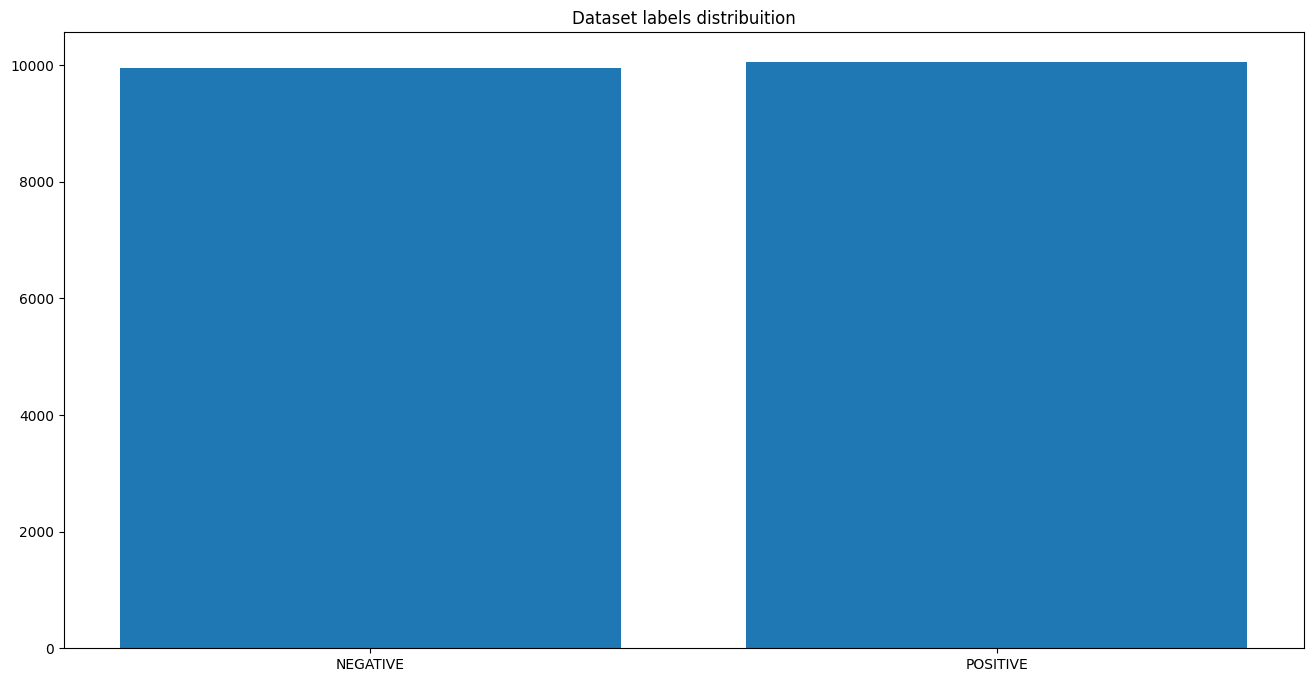

In [11]:
# Visulizing the positive and negative counts

positive_count = Counter(data.is_positive)

plt.figure(figsize=(16,8))
plt.bar(positive_count.keys(), positive_count.values())
plt.title("Dataset labels distribuition")

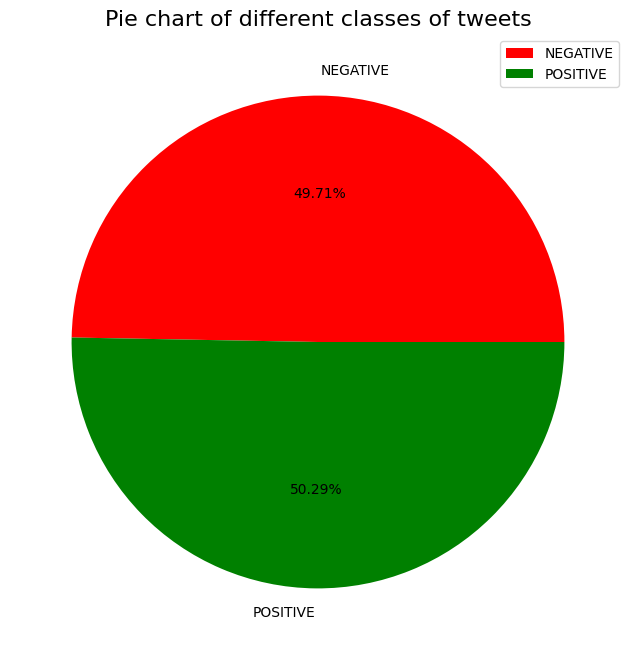

In [12]:
# Visulizing the positive and negative counts with pie chart

fig = plt.figure(figsize=(8,8))
targets = data.groupby('is_positive').size()
targets.plot(kind='pie', subplots=True, figsize=(10, 8), autopct = "%.2f%%", colors=['red','green'])
plt.title("Pie chart of different classes of tweets",fontsize=16)
plt.ylabel("")
plt.legend()
plt.show()

In [13]:
# importing libraries for data preprocessing

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [14]:
# removing stopwords

stop_words = set(stopwords.words("english"))
stop_words.remove('not')
more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
stop_words = stop_words.union(more_stopwords)

stemmer = SnowballStemmer("english")

In [15]:
# removing url, emoji, html, punctuations and quotes in the data

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'^[^ ]<.*?>|&([a-z0-9]+|#[0-9]\"\'\â€œ{1,6}|#x[0-9a-f]{1,6});[^A-Za-z0-9]+')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def remove_quotes(text):
    quotes = re.compile(r'[^A-Za-z0-9\s]+')
    return re.sub(quotes, '', text)


# Applying helper functions

data['text'] = data['message'].apply(lambda x: remove_URL(x))
data['text'] = data['text'].apply(lambda x: remove_emoji(x))
data['text'] = data['text'].apply(lambda x: remove_html(x))
data['text'] = data['text'].apply(lambda x: remove_punct(x))
data['text'] = data['text'].apply(lambda x: remove_quotes(x))
data.head()

,is_positive,message,text
0,NEGATIVE,@Nkluvr4eva My poor little dumpling In Holmde...,Nkluvr4eva My poor little dumpling In Holmdel...
1,NEGATIVE,I'm off too bed. I gotta wake up hella early t...,Im off too bed I gotta wake up hella early tom...
2,NEGATIVE,I havent been able to listen to it yet My spe...,I havent been able to listen to it yet My spe...
3,NEGATIVE,now remembers why solving a relatively big equ...,now remembers why solving a relatively big equ...
4,NEGATIVE,"Ate too much, feel sick",Ate too much feel sick


In [16]:
# tokanizing the text and appending the column

data['tokenized'] = data['text'].apply(word_tokenize)

data.head()

,is_positive,message,text,tokenized
0,NEGATIVE,@Nkluvr4eva My poor little dumpling In Holmde...,Nkluvr4eva My poor little dumpling In Holmdel...,"[Nkluvr4eva, My, poor, little, dumpling, In, H..."
1,NEGATIVE,I'm off too bed. I gotta wake up hella early t...,Im off too bed I gotta wake up hella early tom...,"[Im, off, too, bed, I, got, ta, wake, up, hell..."
2,NEGATIVE,I havent been able to listen to it yet My spe...,I havent been able to listen to it yet My spe...,"[I, havent, been, able, to, listen, to, it, ye..."
3,NEGATIVE,now remembers why solving a relatively big equ...,now remembers why solving a relatively big equ...,"[now, remembers, why, solving, a, relatively, ..."
4,NEGATIVE,"Ate too much, feel sick",Ate too much feel sick,"[Ate, too, much, feel, sick]"


In [17]:
# lowercase

data['lower'] = data['tokenized'].apply(
    lambda x: [word.lower() for word in x])

data.head()

,is_positive,message,text,tokenized,lower
0,NEGATIVE,@Nkluvr4eva My poor little dumpling In Holmde...,Nkluvr4eva My poor little dumpling In Holmdel...,"[Nkluvr4eva, My, poor, little, dumpling, In, H...","[nkluvr4eva, my, poor, little, dumpling, in, h..."
1,NEGATIVE,I'm off too bed. I gotta wake up hella early t...,Im off too bed I gotta wake up hella early tom...,"[Im, off, too, bed, I, got, ta, wake, up, hell...","[im, off, too, bed, i, got, ta, wake, up, hell..."
2,NEGATIVE,I havent been able to listen to it yet My spe...,I havent been able to listen to it yet My spe...,"[I, havent, been, able, to, listen, to, it, ye...","[i, havent, been, able, to, listen, to, it, ye..."
3,NEGATIVE,now remembers why solving a relatively big equ...,now remembers why solving a relatively big equ...,"[now, remembers, why, solving, a, relatively, ...","[now, remembers, why, solving, a, relatively, ..."
4,NEGATIVE,"Ate too much, feel sick",Ate too much feel sick,"[Ate, too, much, feel, sick]","[ate, too, much, feel, sick]"


In [18]:
# adding the column after removing the stopwords

data['stopwords_removed'] = data['lower'].apply(
    lambda x: [word for word in x if word not in stop_words])

data.head()

,is_positive,message,text,tokenized,lower,stopwords_removed
0,NEGATIVE,@Nkluvr4eva My poor little dumpling In Holmde...,Nkluvr4eva My poor little dumpling In Holmdel...,"[Nkluvr4eva, My, poor, little, dumpling, In, H...","[nkluvr4eva, my, poor, little, dumpling, in, h...","[nkluvr4eva, poor, little, dumpling, holmdel, ..."
1,NEGATIVE,I'm off too bed. I gotta wake up hella early t...,Im off too bed I gotta wake up hella early tom...,"[Im, off, too, bed, I, got, ta, wake, up, hell...","[im, off, too, bed, i, got, ta, wake, up, hell...","[im, bed, got, ta, wake, hella, early, tomorro..."
2,NEGATIVE,I havent been able to listen to it yet My spe...,I havent been able to listen to it yet My spe...,"[I, havent, been, able, to, listen, to, it, ye...","[i, havent, been, able, to, listen, to, it, ye...","[havent, able, listen, yet, speakers, busted]"
3,NEGATIVE,now remembers why solving a relatively big equ...,now remembers why solving a relatively big equ...,"[now, remembers, why, solving, a, relatively, ...","[now, remembers, why, solving, a, relatively, ...","[remembers, solving, relatively, big, equation..."
4,NEGATIVE,"Ate too much, feel sick",Ate too much feel sick,"[Ate, too, much, feel, sick]","[ate, too, much, feel, sick]","[ate, much, feel, sick]"


In [19]:
# parts of speech tagging

data['pos_tags'] = data['stopwords_removed'].apply(nltk.tag.pos_tag)

data.head()

,is_positive,message,text,tokenized,lower,stopwords_removed,pos_tags
0,NEGATIVE,@Nkluvr4eva My poor little dumpling In Holmde...,Nkluvr4eva My poor little dumpling In Holmdel...,"[Nkluvr4eva, My, poor, little, dumpling, In, H...","[nkluvr4eva, my, poor, little, dumpling, in, h...","[nkluvr4eva, poor, little, dumpling, holmdel, ...","[(nkluvr4eva, JJ), (poor, JJ), (little, JJ), (..."
1,NEGATIVE,I'm off too bed. I gotta wake up hella early t...,Im off too bed I gotta wake up hella early tom...,"[Im, off, too, bed, I, got, ta, wake, up, hell...","[im, off, too, bed, i, got, ta, wake, up, hell...","[im, bed, got, ta, wake, hella, early, tomorro...","[(im, NN), (bed, NN), (got, VBD), (ta, JJ), (w..."
2,NEGATIVE,I havent been able to listen to it yet My spe...,I havent been able to listen to it yet My spe...,"[I, havent, been, able, to, listen, to, it, ye...","[i, havent, been, able, to, listen, to, it, ye...","[havent, able, listen, yet, speakers, busted]","[(havent, NN), (able, JJ), (listen, NN), (yet,..."
3,NEGATIVE,now remembers why solving a relatively big equ...,now remembers why solving a relatively big equ...,"[now, remembers, why, solving, a, relatively, ...","[now, remembers, why, solving, a, relatively, ...","[remembers, solving, relatively, big, equation...","[(remembers, NNS), (solving, VBG), (relatively..."
4,NEGATIVE,"Ate too much, feel sick",Ate too much feel sick,"[Ate, too, much, feel, sick]","[ate, too, much, feel, sick]","[ate, much, feel, sick]","[(ate, RB), (much, JJ), (feel, NN), (sick, JJ)]"


In [20]:
# wordnet pos tagging (adjectives, verbs, nouns and adverbs)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


data['wordnet_pos'] = data['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

data.head()

,is_positive,message,text,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos
0,NEGATIVE,@Nkluvr4eva My poor little dumpling In Holmde...,Nkluvr4eva My poor little dumpling In Holmdel...,"[Nkluvr4eva, My, poor, little, dumpling, In, H...","[nkluvr4eva, my, poor, little, dumpling, in, h...","[nkluvr4eva, poor, little, dumpling, holmdel, ...","[(nkluvr4eva, JJ), (poor, JJ), (little, JJ), (...","[(nkluvr4eva, a), (poor, a), (little, a), (dum..."
1,NEGATIVE,I'm off too bed. I gotta wake up hella early t...,Im off too bed I gotta wake up hella early tom...,"[Im, off, too, bed, I, got, ta, wake, up, hell...","[im, off, too, bed, i, got, ta, wake, up, hell...","[im, bed, got, ta, wake, hella, early, tomorro...","[(im, NN), (bed, NN), (got, VBD), (ta, JJ), (w...","[(im, n), (bed, n), (got, v), (ta, a), (wake, ..."
2,NEGATIVE,I havent been able to listen to it yet My spe...,I havent been able to listen to it yet My spe...,"[I, havent, been, able, to, listen, to, it, ye...","[i, havent, been, able, to, listen, to, it, ye...","[havent, able, listen, yet, speakers, busted]","[(havent, NN), (able, JJ), (listen, NN), (yet,...","[(havent, n), (able, a), (listen, n), (yet, r)..."
3,NEGATIVE,now remembers why solving a relatively big equ...,now remembers why solving a relatively big equ...,"[now, remembers, why, solving, a, relatively, ...","[now, remembers, why, solving, a, relatively, ...","[remembers, solving, relatively, big, equation...","[(remembers, NNS), (solving, VBG), (relatively...","[(remembers, n), (solving, v), (relatively, r)..."
4,NEGATIVE,"Ate too much, feel sick",Ate too much feel sick,"[Ate, too, much, feel, sick]","[ate, too, much, feel, sick]","[ate, much, feel, sick]","[(ate, RB), (much, JJ), (feel, NN), (sick, JJ)]","[(ate, r), (much, a), (feel, n), (sick, a)]"


In [21]:
# lemmatization and appending the string of lemmatized objects

wnl = WordNetLemmatizer()

data['lemmatized'] = data['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

data['lemmatized'] = data['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop_words])

data['lemma_str'] = [' '.join(map(str, l)) for l in data['lemmatized']]

data.head()

,is_positive,message,text,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,NEGATIVE,@Nkluvr4eva My poor little dumpling In Holmde...,Nkluvr4eva My poor little dumpling In Holmdel...,"[Nkluvr4eva, My, poor, little, dumpling, In, H...","[nkluvr4eva, my, poor, little, dumpling, in, h...","[nkluvr4eva, poor, little, dumpling, holmdel, ...","[(nkluvr4eva, JJ), (poor, JJ), (little, JJ), (...","[(nkluvr4eva, a), (poor, a), (little, a), (dum...","[nkluvr4eva, poor, little, dumpling, holmdel, ...",nkluvr4eva poor little dumpling holmdel vids r...
1,NEGATIVE,I'm off too bed. I gotta wake up hella early t...,Im off too bed I gotta wake up hella early tom...,"[Im, off, too, bed, I, got, ta, wake, up, hell...","[im, off, too, bed, i, got, ta, wake, up, hell...","[im, bed, got, ta, wake, hella, early, tomorro...","[(im, NN), (bed, NN), (got, VBD), (ta, JJ), (w...","[(im, n), (bed, n), (got, v), (ta, a), (wake, ...","[im, bed, get, ta, wake, hella, early, tomorro...",im bed get ta wake hella early tomorrow morning
2,NEGATIVE,I havent been able to listen to it yet My spe...,I havent been able to listen to it yet My spe...,"[I, havent, been, able, to, listen, to, it, ye...","[i, havent, been, able, to, listen, to, it, ye...","[havent, able, listen, yet, speakers, busted]","[(havent, NN), (able, JJ), (listen, NN), (yet,...","[(havent, n), (able, a), (listen, n), (yet, r)...","[havent, able, listen, yet, speaker, bust]",havent able listen yet speaker bust
3,NEGATIVE,now remembers why solving a relatively big equ...,now remembers why solving a relatively big equ...,"[now, remembers, why, solving, a, relatively, ...","[now, remembers, why, solving, a, relatively, ...","[remembers, solving, relatively, big, equation...","[(remembers, NNS), (solving, VBG), (relatively...","[(remembers, n), (solving, v), (relatively, r)...","[remembers, solve, relatively, big, equation, ...",remembers solve relatively big equation two un...
4,NEGATIVE,"Ate too much, feel sick",Ate too much feel sick,"[Ate, too, much, feel, sick]","[ate, too, much, feel, sick]","[ate, much, feel, sick]","[(ate, RB), (much, JJ), (feel, NN), (sick, JJ)]","[(ate, r), (much, a), (feel, n), (sick, a)]","[ate, much, feel, sick]",ate much feel sick


In [22]:
print('Total Rows =', len(data.text))

Total Rows = 20000


In [23]:
# dropping columns to obtain features and labels

data_mod = data[["is_positive", "lemma_str"]]
data_mod.head()

,is_positive,lemma_str
0,NEGATIVE,nkluvr4eva poor little dumpling holmdel vids r...
1,NEGATIVE,im bed get ta wake hella early tomorrow morning
2,NEGATIVE,havent able listen yet speaker bust
3,NEGATIVE,remembers solve relatively big equation two un...
4,NEGATIVE,ate much feel sick


In [24]:
#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
import tensorflow as tf

In [25]:
# splitting the data for training and testing

train, test = train_test_split(data_mod, test_size=0.2, random_state=42)
print("Train dataset shape: {}".format(train.shape))
print("Test dataset shape: {}".format(test.shape))

Train dataset shape: (16000, 2)
Test dataset shape: (4000, 2)


In [26]:
# tokenizer from tensorflow.kearas.preprocessing

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.lemma_str)
vocab_size = len(tokenizer.word_index) + 1
max_length = 50

In [28]:
# converting text data into sequence of token indices, where each word in the texts is replaced by its corresponding index in the vocabulary.

sequences_train = tokenizer.texts_to_sequences(train.lemma_str)
sequences_test = tokenizer.texts_to_sequences(test.lemma_str)

# padding or truncation to obtain uniform length

X_train = pad_sequences(sequences_train, maxlen=max_length, padding='post')
X_test = pad_sequences(sequences_test, maxlen=max_length, padding='post')

y_train = np.array([0. if item == "NEGATIVE" else 1. for item in train.is_positive.values])
y_test = np.array([0. if item == "NEGATIVE" else 1. for item in test.is_positive.values])

In [29]:
# loading pretrained embeddings from glove (Global Vectors for Word Representation)

embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('/content/glove.6B.100d.txt')

# mapping words to thier repective embedding vector

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions #parsing and extracting the word and its vector dimensions

glove_file.close()

# vector matrix for the words in the vocabulary

embeddings_matrix = np.zeros((vocab_size, embedding_dim)) # row-> word, column->emb_dim
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector

In [31]:
# embedding layer and setting up the training parameters

EPOCHS = 10
BATCH_SIZE = 100

embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length,
                                            weights=[embeddings_matrix], trainable=False)
""" Args
      'vocab_size': size of the vocabulary, number of unique words
      'embedding_dim': dimensionality of the embedding space (match the dimensionality of the pre-trained GloVe vectors)
      'input_length': length of input sequences (padded to max_length)
      'weights': initial weights of the embedding layer (pre-trained embedding matrix)
      'trainable': Setting trainable to False (pre-trained emb)"""

In [32]:
model = Sequential([
        embedding_layer,
        tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)),
        tf.keras.layers.Dropout(0.3), #to prevent overfitting
        tf.keras.layers.Bidirectional(LSTM(128)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'), #dense layer with relu activation
        tf.keras.layers.Dense(1, activation='sigmoid'), #sigmoid activation for binary classification
    ])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           2506400   
                                                                 
 bidirectional (Bidirection  (None, 50, 256)           234496    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 50, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                1

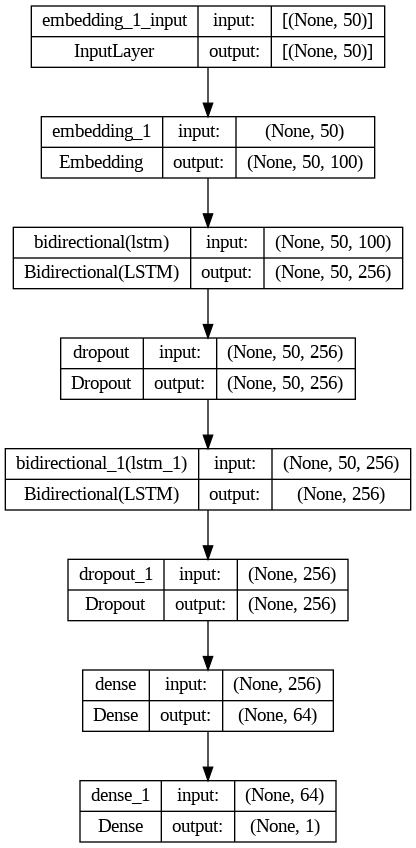

In [34]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [35]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size = BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_test, y_test), verbose=2)

Epoch 1/10
160/160 - 13s - loss: 0.6105 - accuracy: 0.6642 - val_loss: 0.5929 - val_accuracy: 0.6812 - 13s/epoch - 79ms/step
Epoch 2/10
160/160 - 2s - loss: 0.5660 - accuracy: 0.6984 - val_loss: 0.5786 - val_accuracy: 0.6965 - 2s/epoch - 16ms/step
Epoch 3/10
160/160 - 2s - loss: 0.5480 - accuracy: 0.7124 - val_loss: 0.5650 - val_accuracy: 0.7113 - 2s/epoch - 15ms/step
Epoch 4/10
160/160 - 3s - loss: 0.5264 - accuracy: 0.7308 - val_loss: 0.5621 - val_accuracy: 0.7095 - 3s/epoch - 16ms/step
Epoch 5/10
160/160 - 3s - loss: 0.5094 - accuracy: 0.7429 - val_loss: 0.5577 - val_accuracy: 0.7170 - 3s/epoch - 16ms/step
Epoch 6/10
160/160 - 3s - loss: 0.4903 - accuracy: 0.7535 - val_loss: 0.5704 - val_accuracy: 0.7172 - 3s/epoch - 16ms/step
Epoch 7/10
160/160 - 2s - loss: 0.4717 - accuracy: 0.7692 - val_loss: 0.5679 - val_accuracy: 0.7135 - 2s/epoch - 15ms/step
Epoch 8/10
160/160 - 2s - loss: 0.4488 - accuracy: 0.7814 - val_loss: 0.6007 - val_accuracy: 0.7182 - 2s/epoch - 15ms/step
Epoch 9/10
160